In [2]:
import requests
import pandas as pd 
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
import folium

In [201]:
# https://opendata.dc.gov/datasets/70392a096a8e431381f1f692aaa06afd_24?geometry=-77.446%2C38.808%2C-76.579%2C38.995

def download_file(url):
    local_filename = "data/accidents.csv"
    # NOTE the stream=True parameter below
    with requests.get(url, stream=True) as r:
        r.raise_for_status()
        with open(local_filename, 'wb') as f:
            for chunk in r.iter_content(chunk_size=16384): 
                if chunk: # filter out keep-alive new chunks
                    f.write(chunk)
                    # f.flush()
    return local_filename

url = "https://opendata.arcgis.com/datasets/70392a096a8e431381f1f692aaa06afd_24.csv"
fileName = download_file(url)

In [4]:
fileName = "data/accidents.csv"
usecolsall = ["X","Y","OBJECTID","CRIMEID","CCN","REPORTDATE","ROUTEID","MEASURE","OFFSET","STREETSEGID","ROADWAYSEGID","FROMDATE","TODATE","MARID","ADDRESS","LATITUDE","LONGITUDE","XCOORD","YCOORD","WARD","EVENTID","MAR_ADDRESS","MAR_SCORE","MAJORINJURIES_BICYCLIST","MINORINJURIES_BICYCLIST","UNKNOWNINJURIES_BICYCLIST","FATAL_BICYCLIST","MAJORINJURIES_DRIVER","MINORINJURIES_DRIVER","UNKNOWNINJURIES_DRIVER","FATAL_DRIVER","MAJORINJURIES_PEDESTRIAN","MINORINJURIES_PEDESTRIAN","UNKNOWNINJURIES_PEDESTRIAN","FATAL_PEDESTRIAN","TOTAL_VEHICLES","TOTAL_BICYCLES","TOTAL_PEDESTRIANS","PEDESTRIANSIMPAIRED","BICYCLISTSIMPAIRED","DRIVERSIMPAIRED","TOTAL_TAXIS","TOTAL_GOVERNMENT","SPEEDING_INVOLVED","NEARESTINTROUTEID","NEARESTINTSTREETNAME","OFFINTERSECTION","INTAPPROACHDIRECTION","LOCATIONERROR","LASTUPDATEDATE","MPDLATITUDE","MPDLONGITUDE","MPDGEOX","MPDGEOY","BLOCKKEY"]
accidentData = pd.read_csv(fileName, usecols=usecolsall)
# get only accidents that include a bike
bikeData = accidentData[accidentData['TOTAL_BICYCLES'] > 0]

/usr/local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (4,54) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
print(list(accidentData))

['X', 'Y', 'OBJECTID', 'CRIMEID', 'CCN', 'REPORTDATE', 'ROUTEID', 'MEASURE', 'OFFSET', 'STREETSEGID', 'ROADWAYSEGID', 'FROMDATE', 'TODATE', 'MARID', 'ADDRESS', 'LATITUDE', 'LONGITUDE', 'XCOORD', 'YCOORD', 'WARD', 'EVENTID', 'MAR_ADDRESS', 'MAR_SCORE', 'MAJORINJURIES_BICYCLIST', 'MINORINJURIES_BICYCLIST', 'UNKNOWNINJURIES_BICYCLIST', 'FATAL_BICYCLIST', 'MAJORINJURIES_DRIVER', 'MINORINJURIES_DRIVER', 'UNKNOWNINJURIES_DRIVER', 'FATAL_DRIVER', 'MAJORINJURIES_PEDESTRIAN', 'MINORINJURIES_PEDESTRIAN', 'UNKNOWNINJURIES_PEDESTRIAN', 'FATAL_PEDESTRIAN', 'TOTAL_VEHICLES', 'TOTAL_BICYCLES', 'TOTAL_PEDESTRIANS', 'PEDESTRIANSIMPAIRED', 'BICYCLISTSIMPAIRED', 'DRIVERSIMPAIRED', 'TOTAL_TAXIS', 'TOTAL_GOVERNMENT', 'SPEEDING_INVOLVED', 'NEARESTINTROUTEID', 'NEARESTINTSTREETNAME', 'OFFINTERSECTION', 'INTAPPROACHDIRECTION', 'LOCATIONERROR', 'LASTUPDATEDATE', 'MPDLATITUDE', 'MPDLONGITUDE', 'MPDGEOX', 'MPDGEOY', 'BLOCKKEY']


In [6]:
smallBikeData = bikeData[['TOTAL_BICYCLES','LATITUDE', 'LONGITUDE', 'XCOORD', 'YCOORD', 'FATAL_BICYCLIST', 'MPDLATITUDE', 'MPDLONGITUDE', 'FROMDATE']]

In [7]:
smallBikeData['FROMDATE'] = pd.to_datetime(smallBikeData['FROMDATE']) 
smallBikeData = smallBikeData[smallBikeData['FROMDATE'] > "2016-12-31"]

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Text(0, 0.5, 'Feature 1')

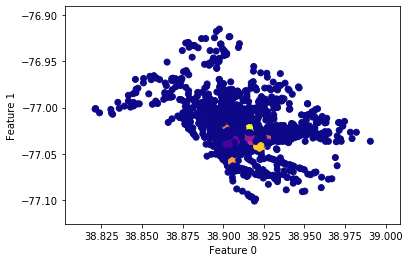

In [44]:
accPoints = np.empty((0, 2))
for lat,long in zip(smallBikeData['LATITUDE'], smallBikeData['LONGITUDE']):
    accPoints = np.append(accPoints, np.array([[lat,long]]), axis=0)

# # generate some random cluster data
# X, y = make_blobs(random_state=170, n_samples=600, centers = 5)
# rng = np.random.RandomState(74)


# # Compute DBSCAN
db = DBSCAN(eps=0.0017, min_samples=20).fit(accPoints)

# worst 3 hubs eps=0.0015, min_samples=25
# more hubs eps=0.0014, min_samples=15

clusters = db.fit_predict(accPoints)
# plot the cluster assignments
plt.scatter(accPoints[:, 0], accPoints[:, 1], c=clusters, cmap="plasma")
plt.xlabel("Feature 0")
plt.ylabel("Feature 1")

In [45]:
print(clusters)
# https://alysivji.github.io/getting-started-with-folium.html
# i think here we make the data into a geo json and after plot that

[-1  0 -1 ... -1 -1 -1]


In [46]:
# plotting all bike accidents
dcMap = folium.Map(location=[38.9072, -77.0369], zoom_start=13)

colorsList = ['red', 'blue', 'black', 'purple', 'orange', 'pink', 'green']
def getColor(ind):
    colorLen = len(colorsList)
    colorNum = ind%colorLen
    color = colorsList[colorNum]
    return color
    


counter = 0
for i in accPoints:
    if (clusters[counter] != -1):
        folium.CircleMarker(location=[i[0], i[1]], 
                            radius = .5,
                            color = getColor(clusters[counter])).add_to(dcMap)
    counter = counter  + 1
dcMap